## Santander Product Recommendation - Part 3
#### Part 3: Visualization and Feature Engineer
This is the work demo for Satandander Product Recommendation Project, which is a also Kaggle Contest. We ranked as 12nd in Public LB and 16th in Private LB. In this project the target was to recommend new products to customers based on their historical behavioral patterns, product purchase records as well as demographic information. The demo will give a step-by-step workflow of my work. Basically this notebook includes:
- Part 1 - Data cleaning
- Part 2 - Feature Bank Generation
- Part 3 - Visualization and Feature Engineer
- Part 4 - Model Training and Validation

**Note:** *We only use training data provided for the demonstration and validation as the true label was not provided in test data*

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
## disable warnings
config_db = "../input/santander_full.sqlite"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import sqlite3 as sq

## connect to database

sq_conn = sq.connect(config_db)

Populating the interactive namespace from numpy and matplotlib


In [2]:
## load data
data_train = pd.read_sql_query("SELECT * FROM data_train_label_stacked;", sq_conn)
data_label_profile = pd.read_sql_query("SELECT * FROM train_active_label_profile;", sq_conn)
print data_train.shape, data_label_profile.shape


(631611, 312) (547571, 20)


In [4]:
data_train = data_train.merge(data_label_profile, how = "left", left_on = ["date_record", "cust_id"], \
                         right_on = ["date_record", "cust_id"], suffixes=['', '_original'])
print data_train.shape

(631611, 330)


In [5]:
## Define feature names and target names
lags_prod = range(1, 12)

cols_product = ["p1_saving_acct", "p2_guarantees", "p3_cur_acct", "p4_deriv_acct", 
"p5_payroll_acct", "p6_junior_acct", "p7_mas_paticular_acct", "p8_particular_acct", "p9_particular_plus_acct", "p10_short_depo", 
"p11_medium_depo", "p12_long_depo", "p13_eacct", "p14_funds", "p15_mortgage", "p16_pensions_plan", "p17_loans", 
"p18_taxes", "p19_credit_card", "p20_securities", "p21_home_acct", "p22_payroll_appt", "p23_pensions_appt", "p24_direct_debit"]

feat_profile_cate = ['idx_active', 'idx_primary', \
                     'type_cust', 'idx_foreigner', 'segmentation', \
                     'idx_new_cust', 'type_cust_relation']
feat_profile_num = ['age', 'income']
feat_prod = [x + "_lag_" + str(y) for x in cols_product for y in lags_prod]
target_prod = [x + "_new" for x in cols_product]


In [18]:
### define visualization modules
def plot_hist_vs_target(df, col_numeric = "age", prod_select = range(0, 24),  bins = 50):
    """
    plot distribution of numerical features vs. target
    
    """
    f, axs = plt.subplots(len(prod_select), 1, sharex=True, figsize=(12,40))
    
    count = 0
    for i in (prod_select):
        axs[count].hist(df.loc[df.loc[:, cols_product[i] + "_new"] == 1, col_numeric], normed = 1, bins = bins)
        axs[count].set_title(cols_product[i] + "_new")
        count += 1

    plt.xlabel('New Product')
    plt.ylabel(col_numeric)
    plt.show()

def plot_bar_vs_target_agg(df, cols_target, col1, col2 = None, ratio = True):
    """
    plot distribution of categorical features vs. target in a compact fashion
    col1: first level categorical feature
    col2: second level categorical feature(optional)
    """
    
    cols_group = [col1] if not col2 else [col1, col2]
      
    df_a = df.loc[:, cols_group].join(df.loc[:, cols_target])
    df_a = df_a.groupby(cols_group).sum()
    df_a = df_a.T    
    
    if ratio:
        # convert to frequency
        df_a = df_a.apply(lambda row: [row[i] / float(sum(row)) for i in xrange(df_a.shape[1])], axis = 1)
    
    df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='Accent')
    plt.title("New Product vs. " + '-'.join(cols_group), fontsize=20) 
    plt.xlabel('Number of Customers', fontsize=17) 
    plt.ylabel('Product Names', fontsize=17) 
    plt.legend(prop={'size':15}, bbox_to_anchor=(1.1, 1.05)) 

    plt.show()

def plot_num_vs_target_agg(df, cols_target, col, bins, ratio = True):
    """
    plot distribution of numerical (binned) features vs. target in a compact fashion
    
    """
    
    df_a = (df.groupby(pd.cut(df[col], bins, right=False)).sum())
      
    df_a = df_a.loc[:, cols_target]
    df_a = df_a.T    
            
    if ratio:
        # convert to frequency
        df_a = df_a.apply(lambda row: [row[i] / float(sum(row)) for i in xrange(df_a.shape[1])], axis = 1)
    
    df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='Accent')
    plt.title("New Product vs. " + col, fontsize=20) 
    plt.xlabel('Number of Customers', fontsize=17) 
    plt.ylabel('Product Names', fontsize=17) 
    plt.legend(prop={'size':15}, bbox_to_anchor=(1.1, 1.05)) 

    plt.show()    
    
    
    

## 1. Target vs. categorical features

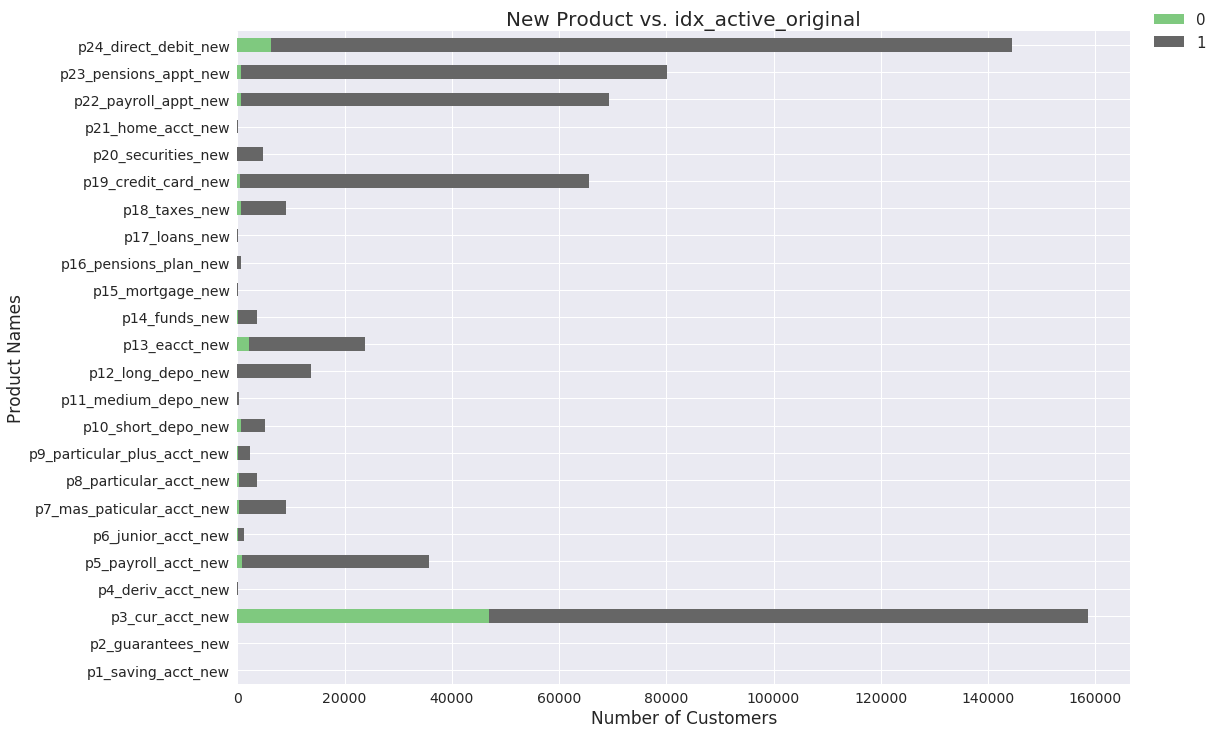

In [7]:
## plot target vs. features - idx_active
plot_bar_vs_target_agg(data_train, cols_target = target_prod, col1 = "idx_active_original", \
                       col2 = None, ratio = False)

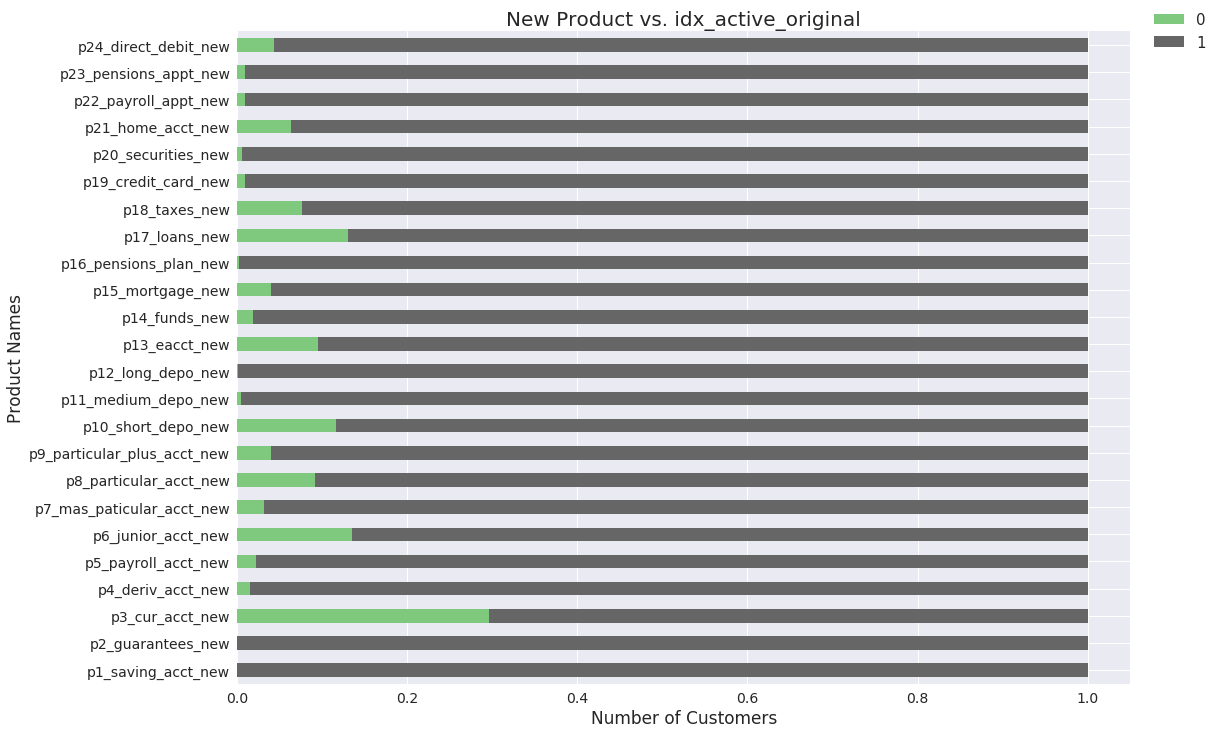

In [9]:
plot_bar_vs_target_agg(data_train, cols_target = target_prod, col1 = "idx_active_original", \
                       col2 = None, ratio = True)

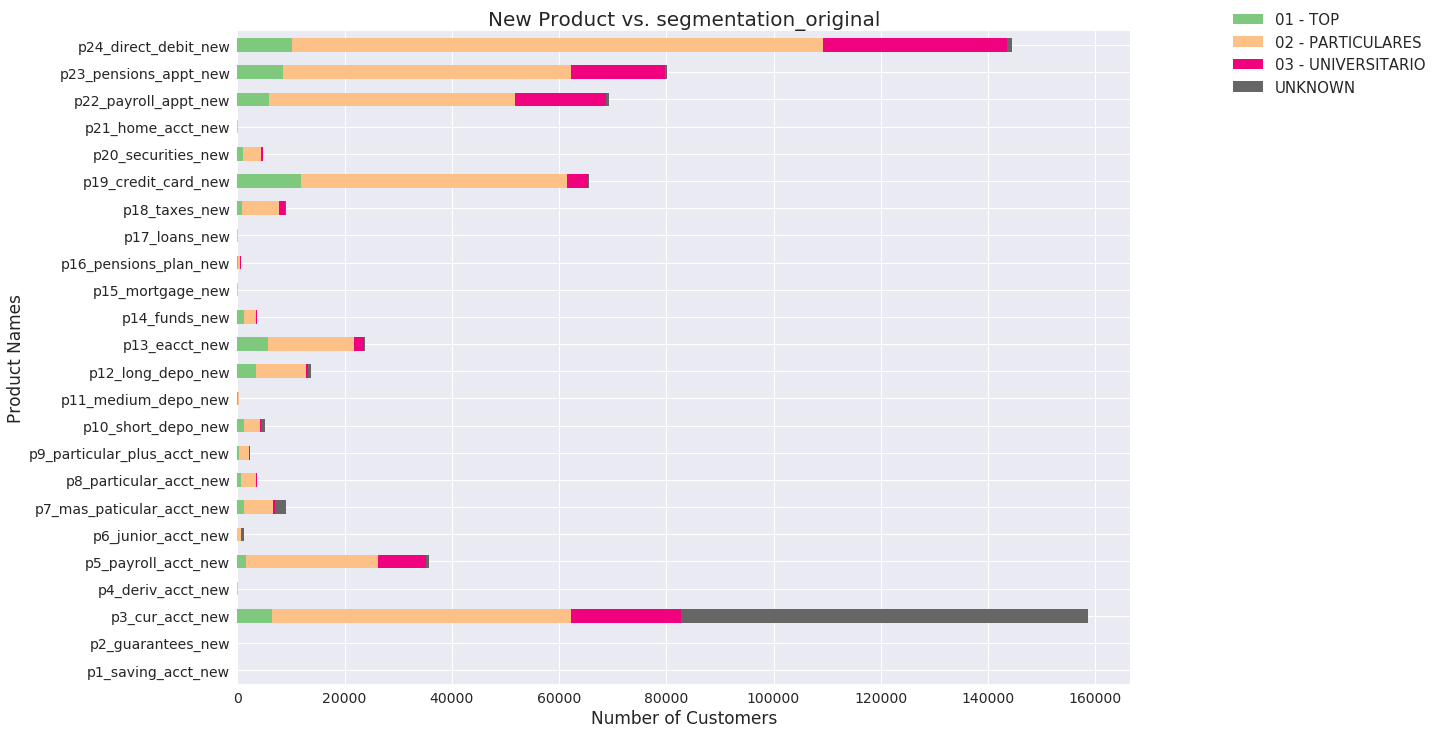

In [10]:
## plot target vs. features - segmentation
plot_bar_vs_target_agg(data_train, cols_target = target_prod, col1 = "segmentation_original", \
                       col2 = None, ratio = False)

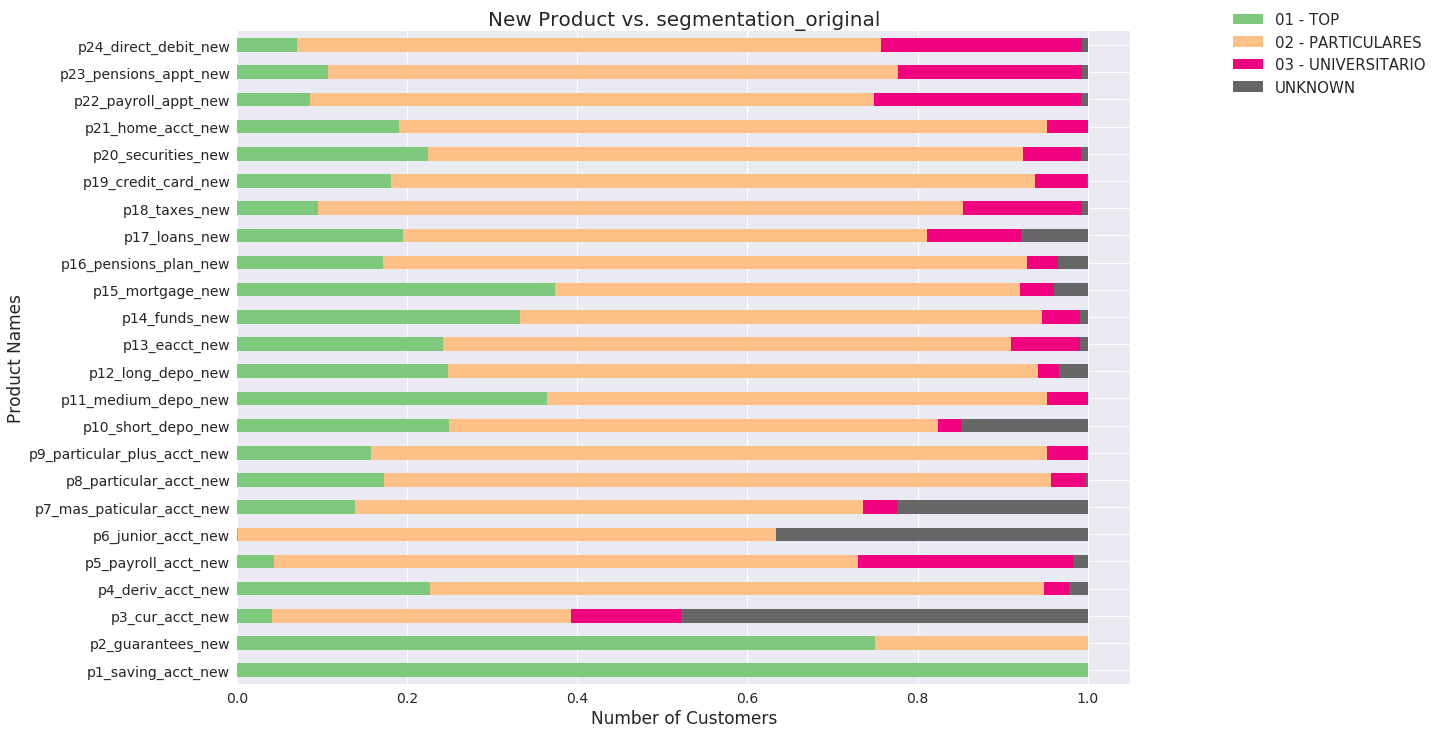

In [11]:
plot_bar_vs_target_agg(data_train, cols_target = target_prod, col1 = "segmentation_original", \
                       col2 = None, ratio = True)

## 2. Target vs. Numerical Features

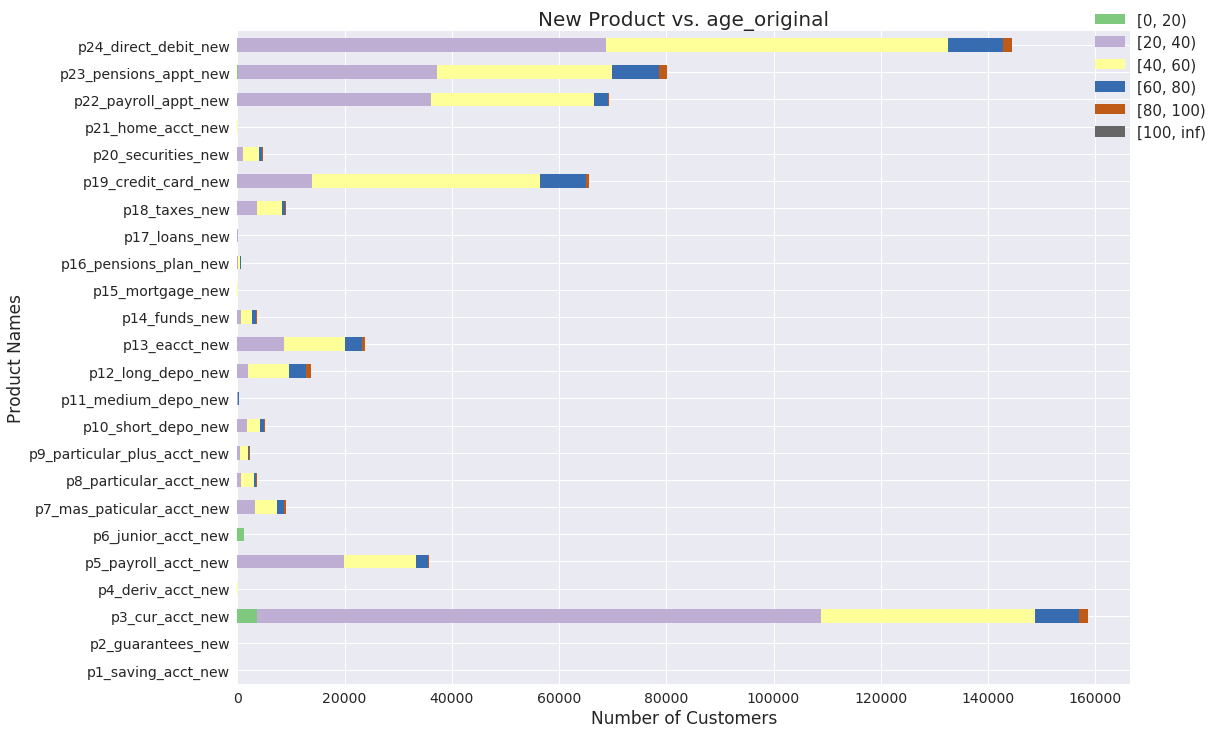

In [19]:
## - Age
plot_num_vs_target_agg(data_train, target_prod,\
                       "age_original", bins = [0,20,40,60,80,100, pd.np.inf], ratio = False)

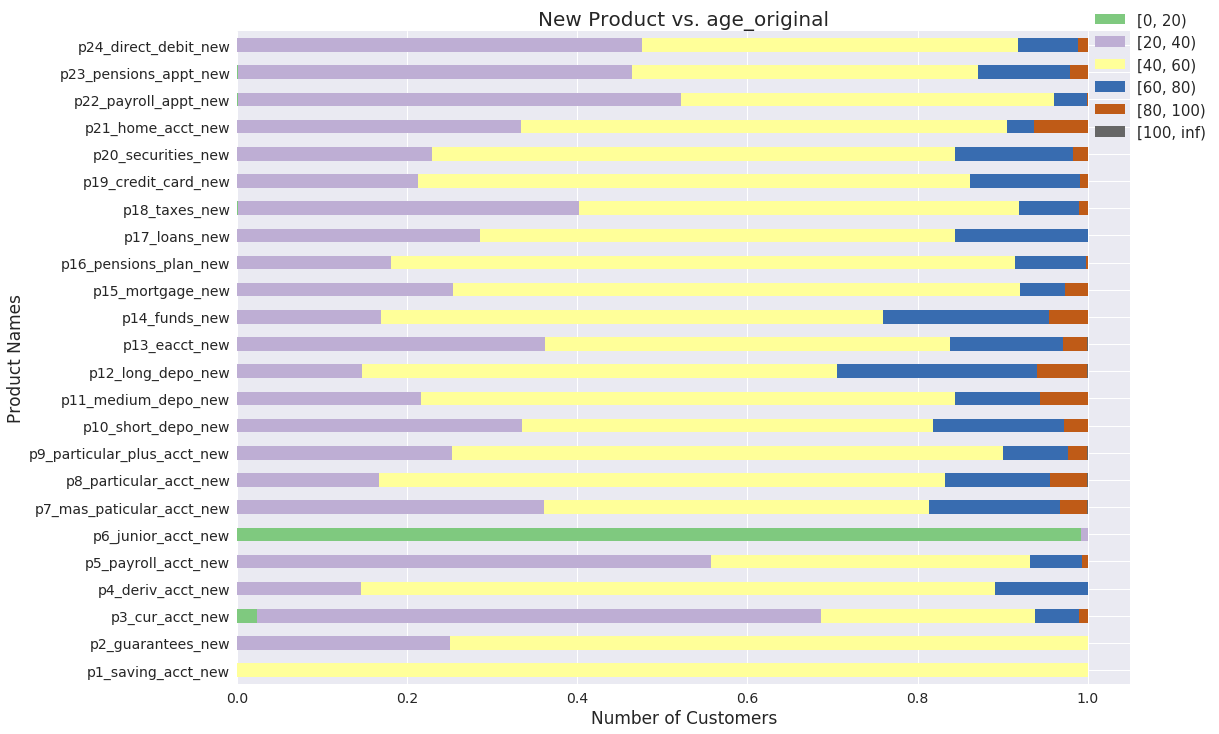

In [20]:
## - Age
plot_num_vs_target_agg(data_train, target_prod,\
                       "age_original", bins = [0,20,40,60,80,100, pd.np.inf], ratio = True)

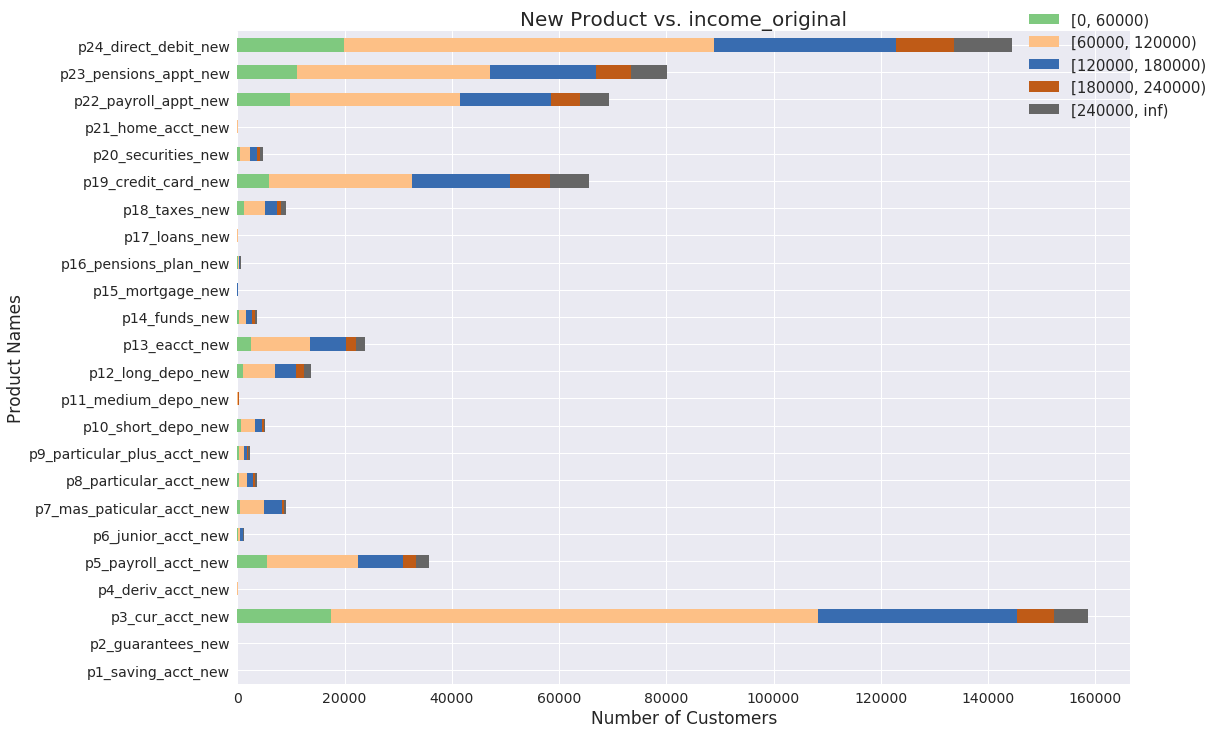

In [21]:
## Income
plot_num_vs_target_agg(data_train, target_prod,\
                       "income_original", bins = [0,60000,120000,180000,240000, pd.np.inf], ratio = False)

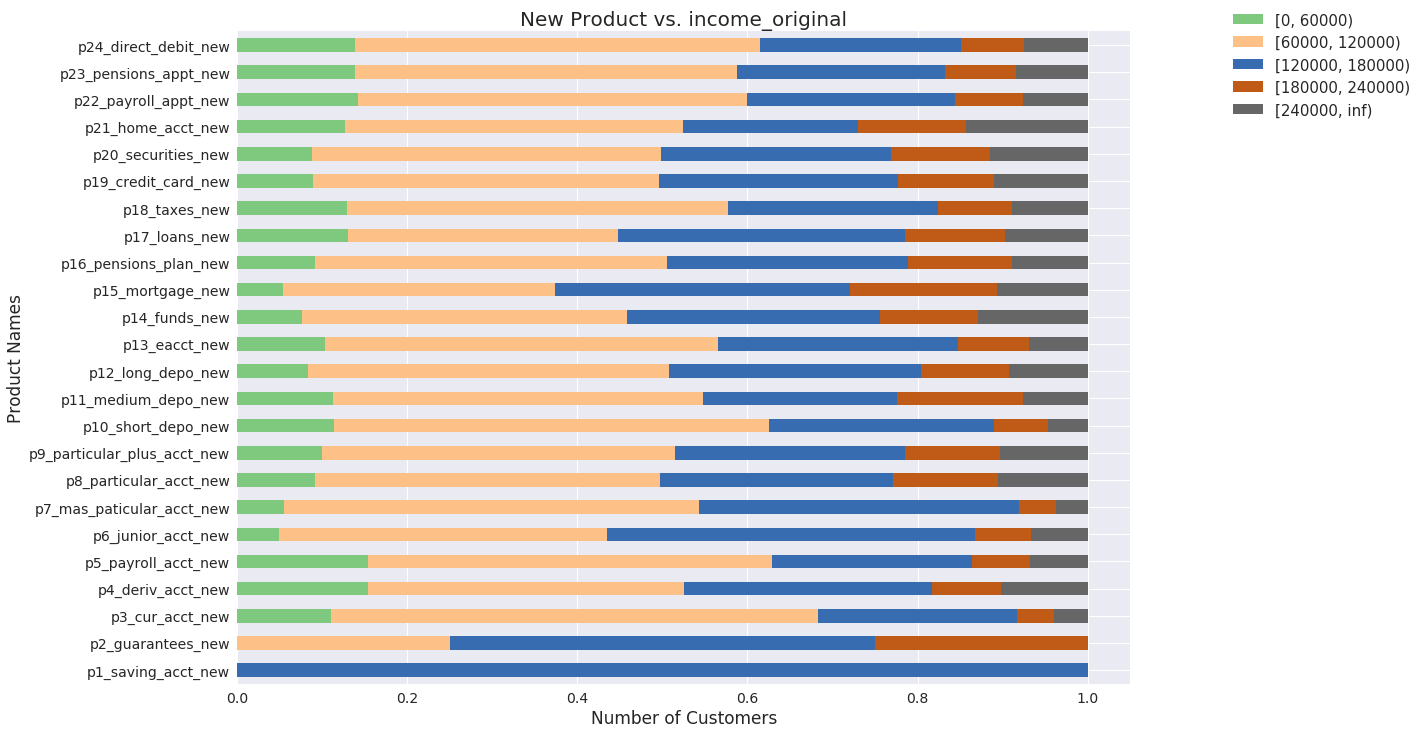

In [22]:
## Income
plot_num_vs_target_agg(data_train, target_prod,\
                       "income_original", bins = [0,60000,120000,180000,240000, pd.np.inf], ratio = True)

## 2. Previous Months product purchase features (lag features)

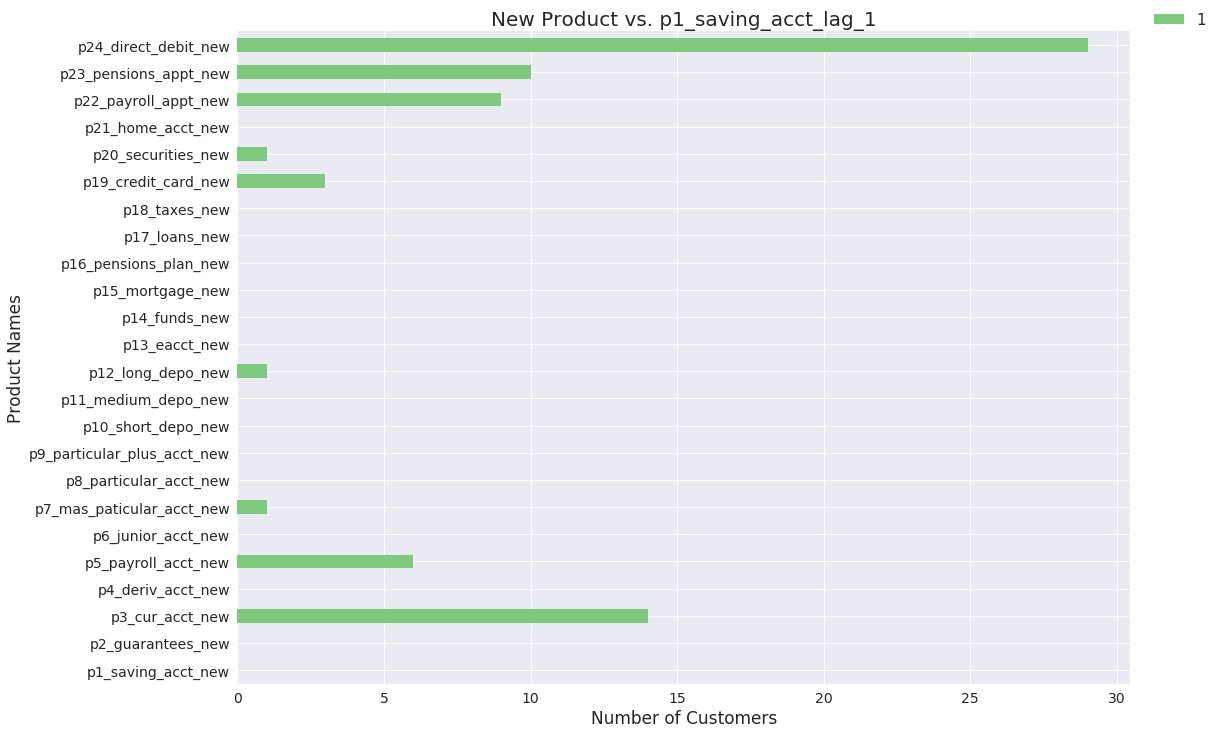

In [26]:
## - p1 - lag 1 
col1 = cols_product[0] + "_lag_1"
plot_bar_vs_target_agg(data_train.loc[data_train.loc[:, col1] == '1', ], cols_target = target_prod, col1 = col1, \
                       col2 = None, ratio = False)

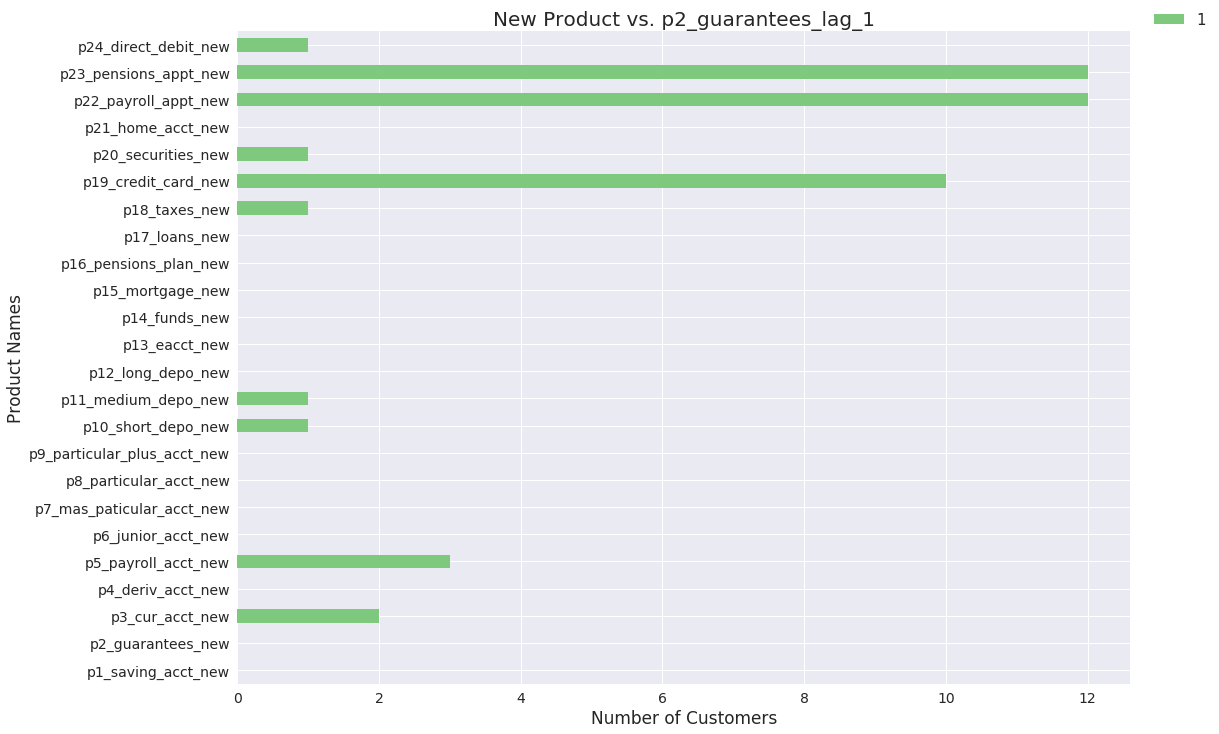

In [27]:
## - p2 - lag 1 
col1 = cols_product[1] + "_lag_1"
plot_bar_vs_target_agg(data_train.loc[data_train.loc[:, col1] == '1', ], cols_target = target_prod, col1 = col1, \
                       col2 = None, ratio = False)

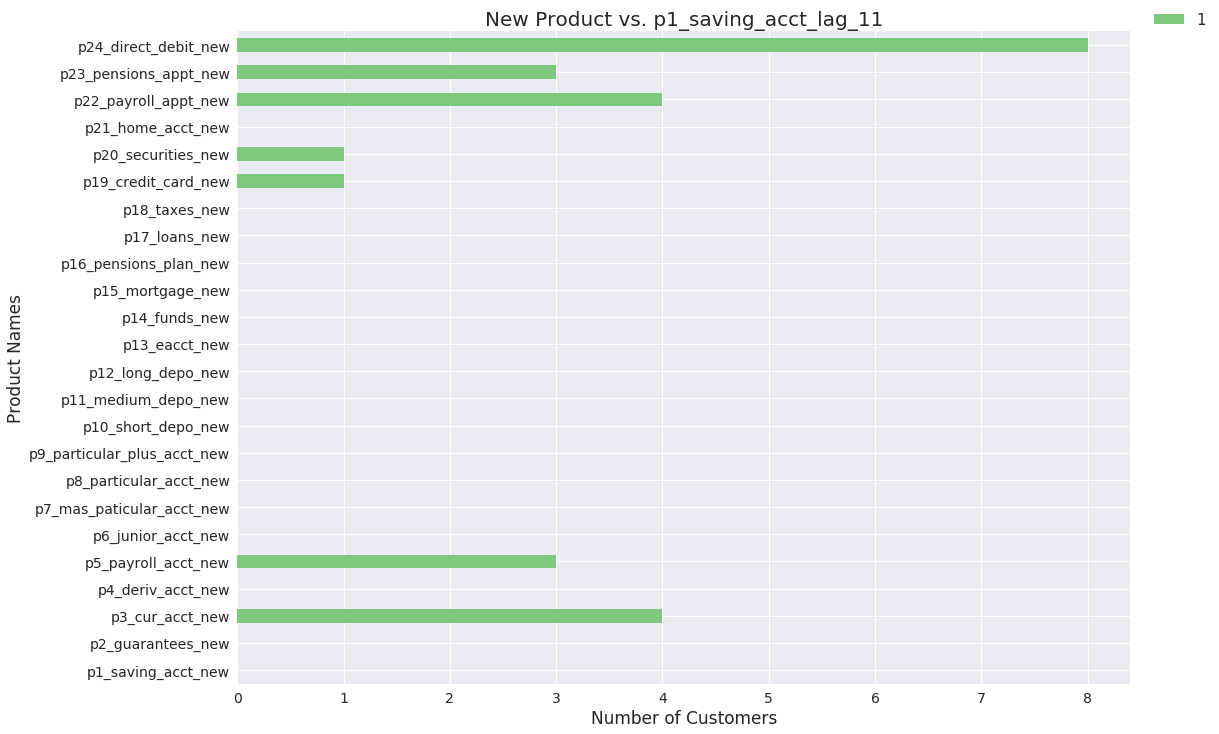

In [29]:
## - p1 - lag 11 
col1 = cols_product[0] + "_lag_11"
plot_bar_vs_target_agg(data_train.loc[data_train.loc[:, col1] == '1', ], cols_target = target_prod, col1 = col1, \
                       col2 = None, ratio = False)

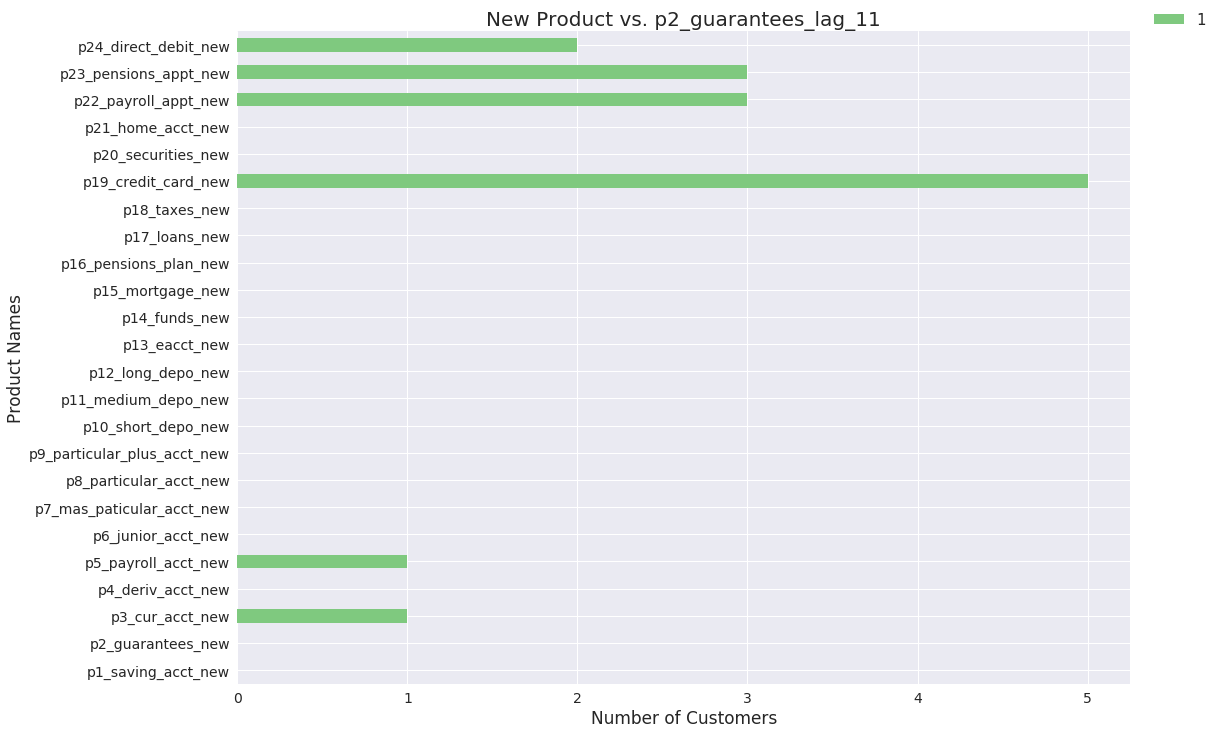

In [28]:
## - p2 - lag 11 
col1 = cols_product[1] + "_lag_11"
plot_bar_vs_target_agg(data_train.loc[data_train.loc[:, col1] == '1', ], cols_target = target_prod, col1 = col1, \
                       col2 = None, ratio = False)